In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pickle
import numpy as np
from text_processing_utils import *
import glob
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
cleaned_ratings = np.array(pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_ratings.pickle", "rb")))
cleaned_reviews = pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_reviews.pickle", "rb"))
vocabulary_dict = pickle.load(open("/content/drive/MyDrive/data/scaledata/vocabulary_dict.pickle", "rb"))

In [4]:
# randomly split the movie reviews data into training/testing parts (80:20)
np.random.seed(7654321)
train_indices = np.random.choice(np.arange(len(cleaned_ratings)), int(len(cleaned_ratings)*0.8), replace=False)
test_indices = np.setdiff1d(np.arange(len(cleaned_ratings)), train_indices)
print(len(train_indices), len(test_indices))
train_bow = convert_bow([cleaned_reviews[i] for i in train_indices])
test_bow = convert_bow([cleaned_reviews[i] for i in test_indices])
train_y = cleaned_ratings[train_indices]
test_y = cleaned_ratings[test_indices]

4004 1002


In [5]:
K = 24 # number of topics
V = len(vocabulary_dict) # vocabulary size

In [6]:
## Loading the optimized global parameters from the model training phase
np.random.seed(12345)
new_alpha = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/alpha.pickle", "rb"))
new_xi = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/xi.pickle", "rb"))
new_eta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/eta.pickle", "rb"))
new_delta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/delta.pickle", "rb"))
new_Lambda = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/Lambda.pickle", "rb"))

input_data_x = test_bow
input_data_y = test_y
fpath = "fragmented_output_files_new/" # where to store the temporary fragmented files during parallelized E steps
if not os.path.exists(fpath[:-1]):
    os.makedirs(fpath[:-1])
else:
    for fn in glob.glob(fpath + "*"):
        os.remove(fn)
epsilon = 1e-4 # stopping criteria for convergence in E step
predict = True # prediction mode for evaluating the test set

## Run one iteration of unsupervised E step (parallelized) to identify the optimal local variational parameters for all documents in the test set.
## The optimized phi identified from the unsupervised batch VI will be used to generate the predictions for response variable y in the test set
%run -i "parallelized_sLDA_E_step.py" # unsupervised batch VI for sLDA is way faster than supervised one
all_gamma = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "gamma*")]
new_gamma_dict = merge_dict(all_gamma)
new_gamma = create_gamma_matrix(new_gamma_dict)
all_phi = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "phi*")]
new_phi = merge_dict(all_phi)

In [7]:
time_elapsed = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/time_elapsed.pickle".format(K), "rb"))
print("Time used to fit the sLDA model:", int(time_elapsed / 60), "minutes")

Time used to fit the sLDA model: 360 minutes


61


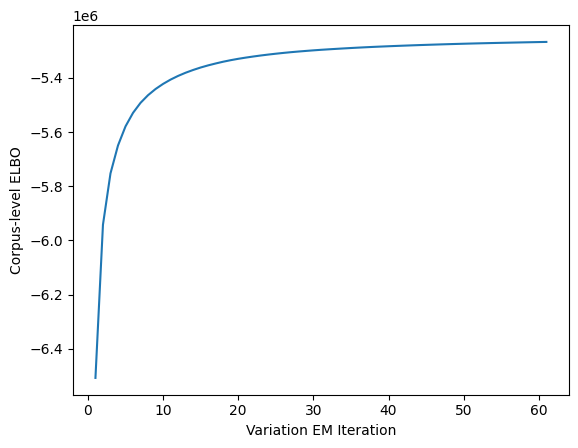

In [8]:
elbo_vs_time = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_1/elbo_vs_time.pickle".format(K), "rb"))
print(len(elbo_vs_time)-1)
plt.plot(np.arange(1, len(elbo_vs_time)), elbo_vs_time[1:])
plt.xlabel("Variation EM Iteration")
plt.ylabel("Corpus-level ELBO")
plt.show()

In [9]:
# Topic words of each topic learned from training sLDA, with corresponding coefficients (eta)
inverse_vocabulary_dict = {v:k for k,v in vocabulary_dict.items()}
for t in range(K):
    word_indices = np.argsort(new_Lambda[t,:])[::-1][:10]
    print("Topic {}:".format(t+1), [inverse_vocabulary_dict[j] for j in word_indices], "eta =", new_eta[t])

Topic 1: ['place', 'emotional', 'visual', 'manner', 'means', 'subtle', 'society', 'development', 'deep', 'opportunity'] eta = 1.1364244225030735
Topic 2: ['sex', 'humor', 'why', 'comes', 'bit', 'gives', 'full', 'seem', 'where', 'enjoyable'] eta = 0.4420615647636575
Topic 3: ['line', 'subject', 'men', 'subscribe', 'details', 'style', 'find', 'job', 'women', 'word'] eta = 0.39568186247362935
Topic 4: ['once', 'day', 'night', 'williams', 'opening', 'proves', 'wife', 'somewhere', 'chris', 'parker'] eta = 0.10748876164862338
Topic 5: ['through', 'take', 'everything', 'away', 'adult', 'novel', 'narrative', 'stories', 'relationship', 'yet'] eta = 0.4820397159716569
Topic 6: ['action', 'big', 'screen', 'star', 'moments', 'lines', 'watching', 'during', 'obvious', 'along'] eta = 0.18379170117931154
Topic 7: ['seems', 'motion', 'however', 'pictures', 'far', 'feature', 'art', 'woman', 'screenplay', 'supporting'] eta = 1.1317945141947745
Topic 8: ['three', 'effective', 'original', 'black', 'use', '

In [10]:
# Generate predictions for the response variable y for the test set:
# For Gaussian response, y_hat = E[phi_bar^T eta]
phi_bar = {k:v.mean(axis=0) for k,v in new_phi.items()}
pred_y = np.empty((len(test_y),))
for indx in range(len(test_y)):
    pred_y[indx] = np.dot(phi_bar[indx], new_eta)

In [11]:
# performance metrics:
def predictive_R2(test_y, pred_y):
    return 1 - np.mean((test_y - pred_y)**2) / np.var(test_y)

print("Predictive R^2 =", predictive_R2(test_y, pred_y))
print("Pearson correlation coefficient =", pearsonr(test_y, pred_y).statistic)

Predictive R^2 = 0.16070449653158947
Pearson correlation coefficient = 0.4065967486190114


In [12]:
new_eta

array([ 1.13642442,  0.44206156,  0.39568186,  0.10748876,  0.48203972,
        0.1837917 ,  1.13179451,  1.45875729,  0.46070972,  0.25641551,
        0.1387021 ,  1.02795156, -0.93195714,  0.58638888,  0.52454162,
        0.71677751,  0.72039065,  0.40534385,  0.55091072,  1.21675862,
        0.79164395,  0.38980191,  0.72135969,  1.28090313])

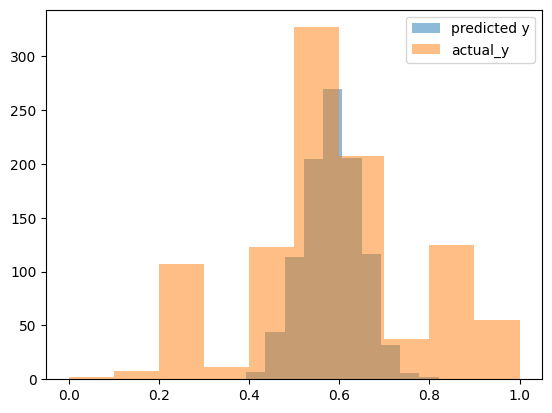

In [16]:
# Compare the predicted histogram of predicted vs. actual y values
plt.hist(pred_y, alpha=0.5, label='x')
plt.hist(test_y, alpha=0.5, label='y')
plt.legend(['predicted y', 'actual_y'], loc='upper right')
plt.show()